In [2]:
'''
Title:  offline Trajektorienplanung
Author: Kaufmann Stefan
Date:   27.03.2023
'''

# Requirements

# python 3.10.6

import numpy as np
import matplotlib.pyplot as plt
import libopc as libs  
import casadi as cas

## Control Lib

In [44]:
import numpy as np
import control as ct
import control.optimal as obc
import matplotlib.pyplot as plt
import libopc as libs

N = 20

def system_update(t, x, u,params):
    # Return the derivative of the state
    return libs.A_simple@x + libs.B_simple*u

def system_output(t, x, u,params):
    return x

def cost(t,x):
    if(x==xf):
        return 0
    else:
        return t

def cost_Scheinleistung(x,u):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    # mit x0 = [i, phi, omega]        
              
    #cost = ((x[0]-xf[0])*u)       #  laufende Kosten  U*I*dt    
    cost =  ((x[:].T-xf[:].T)@Q@(x[:]-xf[:]))/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)       
    cost += u[:].T@R@u[:]/2
               
    return cost


# Define the vehicle steering dynamics as an input/output system
Quanser = ct.NonlinearIOSystem(
    system_update, system_output, states=3, name='Quanser',
    inputs=('u'), outputs=('i','phi','omega'))


x0 = np.array([0., 0., 0.]); u0 = np.array([0.])
xf = np.array([0, np.pi/2., 0.]); uf = np.array([0.])
Tf = 2

Q = np.diag([0, 10, 0])          # don't turn too sharply
R = np.diag([0.1])               # keep inputs small
P = np.diag([0, 10, 0])   # get close to final point
traj_cost = obc.quadratic_cost(Quanser, Q, R, x0=xf, u0=uf)
term_cost = obc.quadratic_cost(Quanser, P, 0, x0=xf)

constraints = [ obc.input_range_constraint(Quanser, [-6],[6]),obc.state_range_constraint(Quanser, [-10, 0, -np.inf], [10, np.inf, np.inf])]

timepts = np.linspace(0, Tf, N, endpoint=True)

result = obc.solve_ocp(
    Quanser, timepts, x0, traj_cost, constraints,
    terminal_cost=term_cost, initial_guess=u0)



Summary statistics:
* Cost function calls: 2754
* Constraint calls: 2870
* System simulations: 1
* Final cost: 6.09967536976176


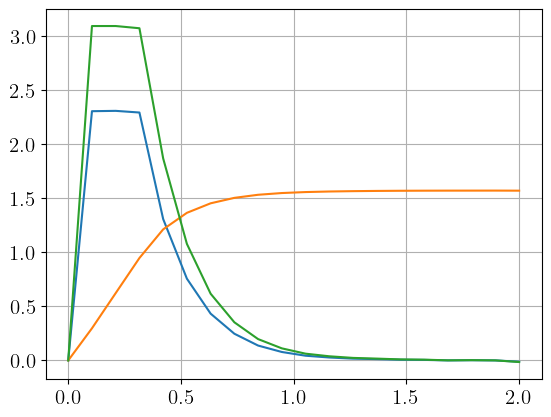

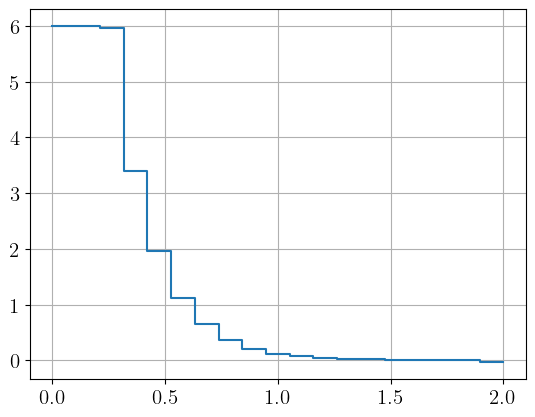

In [45]:
# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    Quanser, timepts, result.inputs, x0,
    t_eval=np.linspace(0, Tf, N))
t, y, u = resp.time, resp.outputs, resp.inputs


plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.plot(t, y[2])
plt.grid()

plt.figure(2)
plt.step(t,u[0])
plt.grid()


# CASADI 

In [10]:
from casadi import *
import Parameter as param

T = 2. # Time horizon
N = 20 # number of control intervals

# Declare model variables
i = MX.sym('i')
phi = MX.sym('phi')
omega = MX.sym('omega')
x = vertcat(i, phi, omega)
u = MX.sym('u')

# Model equations
xdot = vertcat(-param.R/param.L*i -param.km/(param.L*param.kg)*omega+1/param.L*u,  omega,  param.ng*param.nm*param.km*param.kg/param.Jeq*i-param.b1/param.Jeq*omega )

# Objective term
L = i**2*0 + phi**2*10 + omega**2*0 +u**2*0.1

# Formulate discrete time dynamics
if True:
   # CVODES from the SUNDIALS suite
   #    
   options=dict(t0=0,tf=T/N) 
   dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
   F = integrator('F', 'cvodes', dae, options)
else:
   # Fixed step Runge-Kutta 4 integrator
   M = 4 # RK4 steps per interval
   DT = T/N/M
   f = Function('f', [x, u], [xdot, L])
   X0 = MX.sym('X0', 2)
   U = MX.sym('U')
   X = X0
   Q = 0
   for j in range(M):
       k1, k1_q = f(X, U)
       k2, k2_q = f(X + DT/2 * k1, U)
       k3, k3_q = f(X + DT/2 * k2, U)
       k4, k4_q = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
   F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])


# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

# Formulate the NLP
Xk = MX([0, 0 ,0])
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    w += [Uk]
    lbw += [-6]
    ubw += [6]
    w0 += [0]

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk = Fk['xf']
    J=J+Fk['qf']    

    # Add inequality constraint
    g += [Xk]
    if k>N-5:
        lbg += [-10,np.pi/2,-inf]
        ubg += [10,np.pi/2,inf]
    else:
        lbg += [-10,-inf,-inf]
        ubg += [10,inf,inf]

# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x']


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       74
Number of nonzeros in inequality constraint Jacobian.:      556
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:       56
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

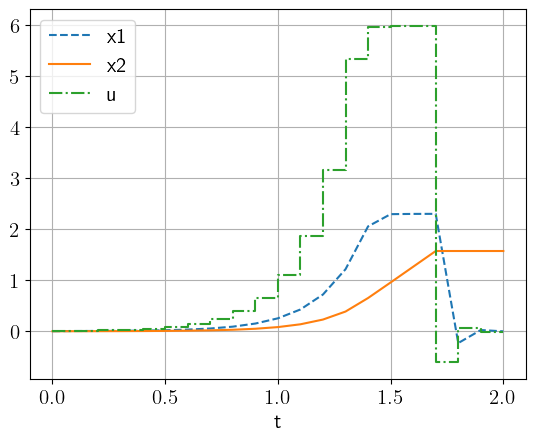

In [11]:
# Plot the solution
u_opt = w_opt
x_opt = [[0, 0, 0]]
for k in range(N):
    Fk = F(x0=x_opt[-1], p=u_opt[k])
    x_opt += [Fk['xf'].full()]
x1_opt = vcat([r[0] for r in x_opt])
x2_opt = vcat([r[1] for r in x_opt])

tgrid = [T/N*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()